# Visualization of differences between Glassdoor's ratings and my scores

In this notebook, I will visualize how I compare companies with my scores compared to how Glassdoor compares companies. This will use the Glassdoor reviews dataset, my dataset on the companies, and my dataset on the ratings of all the companies.

In [1]:
import pandas as pd
pd.set_option('display.max_columns',100)
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#set default seaborn plotting style
sns.set_style('white')

import time



## Import Glassdoor reviews and companies data

In [2]:
start_time = time.time()

reviews = pd.read_csv('glassdoor_reviews_2.csv')

original_reviews = reviews.copy()

#each review's "Author Title" should be of format "Employee Status - Job Title"
# for example, "Current Employee - Senior Engineer"

#determine how many parts each review's "Author Title" has (should be 2)
reviews.loc[:,'title_length'] = reviews.loc[:,'Author Title'].apply(lambda x: len(x.split(' - ')))

#only consider reviews of proper format "Employee Status - Author Title"
reviews = reviews[reviews['title_length'] == 2]
#could be omitting some job titles with 'dash' in name,
#but decreasing number of reviews from 2631927 to 2615691 (<1% change, so don't care)

#'Author Title' of all reviews now 2
reviews = reviews.drop('title_length', axis=1)

#break up "Author Title" into two columns: "Employee Status" and "Job Title"
reviews.loc[:,'Employee Status'] = reviews.loc[:,'Author Title'].apply(lambda x: x.split(' - ')[0])
reviews.loc[:,'Job Title'] = reviews.loc[:,'Author Title'].apply(lambda x: x.split(' - ')[1])

#remove 10 reviews have incorrect "Employee Status" 
#("Employee Status" not like "Current Employee", "Former Intern", etc.)
reviews = reviews[reviews['Employee Status'] != 'module.emp-review.current-'] #remove 4 reviews
reviews = reviews[reviews['Employee Status'] != 'module.emp-review.former-'] #remove 6 reviews

#add extra columns that states if employee is current or former employee
reviews.loc[:,'current_or_former'] = reviews.loc[:,'Employee Status'].apply(lambda x: x.split(' ')[0])

print('Took ' + str(time.time()-start_time) + ' seconds.')

/Users/derekjung/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Took 91.74248003959656 seconds.


In [4]:
original_reviews = reviews.copy()

In [5]:
reviews = original_reviews.copy()

companies = pd.read_csv('reviewed_companies.csv', index_col='Unnamed: 0')

#only consider companies with at least this many reviews
min_reviews = 500

#company ID's of companies with at least 500 reviews
company_ids_at_least_min_reviews = companies[companies['count'] >= min_reviews].loc[:,'Company Id']

#only consider reviews of companies with at least 500 reviews
reviews = reviews[reviews['Company Id'].isin(company_ids_at_least_min_reviews)]

In [6]:
#273 companies with at least 500 reviews
reviews.loc[:,'Company Id'].nunique()

273

## Find my weighted scores for companies

I scored each companies in 5 categories and for PRO/CON. Thus, I created 10 scores for each company. However, Glassdoor only gives a single score for each for each category.

Here, I will combine the PRO and CON scores for each category to create a single score for each category. I will do this by taking a weighted average based on how many PRO and CON sentences there are for each company. 

In [8]:
#Pros and Cons ratings of companies
pros_cons_by_company = pd.read_csv('companies_pros_cons_ratings.csv', index_col='Unnamed: 0')

In [9]:
#only consider companies with at least 500 reviews
pros_cons_by_company = pros_cons_by_company[pros_cons_by_company['Company Id'].isin(company_ids_at_least_min_reviews)]

#set Company ID to be index
pros_cons_by_company = pros_cons_by_company.set_index('Company Id', drop=True)

In [10]:
print(pros_cons_by_company.columns)
pros_cons_by_company.head()

Index(['PROs Culture & Values mean', 'PROs Work/Life Balance mean',
       'PROs Senior Management mean', 'PROs Comp & Benefits mean',
       'PROs Career Opportunities mean', 'CONs Culture & Values mean',
       'CONs Work/Life Balance mean', 'CONs Senior Management mean',
       'CONs Comp & Benefits mean', 'CONs Career Opportunities mean',
       'PROs Culture & Values count', 'PROs Work/Life Balance count',
       'PROs Senior Management count', 'PROs Comp & Benefits count',
       'PROs Career Opportunities count', 'CONs Culture & Values count',
       'CONs Work/Life Balance count', 'CONs Senior Management count',
       'CONs Comp & Benefits count', 'CONs Career Opportunities count'],
      dtype='object')


,PROs Culture & Values mean,PROs Work/Life Balance mean,PROs Senior Management mean,PROs Comp & Benefits mean,PROs Career Opportunities mean,CONs Culture & Values mean,CONs Work/Life Balance mean,CONs Senior Management mean,CONs Comp & Benefits mean,CONs Career Opportunities mean,PROs Culture & Values count,PROs Work/Life Balance count,PROs Senior Management count,PROs Comp & Benefits count,PROs Career Opportunities count,CONs Culture & Values count,CONs Work/Life Balance count,CONs Senior Management count,CONs Comp & Benefits count,CONs Career Opportunities count
Company Id,,,,,,,,,,,,,,,,,,,,
8,0.532774,0.519078,0.469322,0.555796,0.495784,-0.069795,-0.010618,-0.098412,-0.056911,0.078058,450.0,281.0,85.0,789.0,204.0,613.0,320.0,395.0,471.0,205.0
12,0.547925,0.536132,0.495026,0.606038,0.528553,-0.017460,-0.028166,-0.034812,0.037819,0.034389,310.0,92.0,78.0,343.0,237.0,395.0,67.0,234.0,107.0,228.0
15,0.527925,0.498453,0.417663,0.500799,0.513879,-0.008189,-0.062289,-0.070796,0.080763,0.087642,686.0,280.0,155.0,281.0,219.0,585.0,87.0,451.0,249.0,275.0
16,0.541245,0.477149,0.473165,0.575033,0.509078,-0.016776,-0.047197,-0.071312,0.062570,0.041209,400.0,283.0,158.0,473.0,246.0,709.0,157.0,398.0,377.0,336.0
28,0.502125,0.457619,0.442790,0.460731,0.529465,-0.014362,-0.079071,-0.055045,0.063999,0.076830,1411.0,532.0,362.0,914.0,893.0,1736.0,462.0,1027.0,1131.0,879.0


In [11]:
#add new columns that gives total score each of 10 category-PRO/CON

categories = ['Culture & Values', 
              'Work/Life Balance', 
              'Senior Management', 
              'Comp & Benefits', 
              'Career Opportunities']

pro_con_cat_list = []

#create 10 new columns for total scores
for pro_con in ['PROs','CONs']:
    for cat in categories:
        pro_con_cat_list.append('{} {} '.format(pro_con, cat))

#calculate total scores for each of 10 bins
for idx in range(10):
    pros_cons_by_company.loc[:, pro_con_cat_list[idx] + 'total'] = \
        pros_cons_by_company.apply(lambda row: row[pro_con_cat_list[idx] + 'count'] * 
                                   row[pro_con_cat_list[idx] + 'mean'],
                                   axis=1)

In [12]:
#calculate total score for each category by adding PRO and CON score
for cat in categories:
    pros_cons_by_company.loc[:,cat + ' total'] = 
        pros_cons_by_company.loc[:,'PROs ' + cat + ' total'] + 
        pros_cons_by_company.loc[:,'CONs ' + cat + ' total']

In [110]:
pros_cons_by_company.head()

,PROs Culture & Values mean,PROs Work/Life Balance mean,PROs Senior Management mean,PROs Comp & Benefits mean,PROs Career Opportunities mean,CONs Culture & Values mean,CONs Work/Life Balance mean,CONs Senior Management mean,CONs Comp & Benefits mean,CONs Career Opportunities mean,PROs Culture & Values count,PROs Work/Life Balance count,PROs Senior Management count,PROs Comp & Benefits count,PROs Career Opportunities count,CONs Culture & Values count,CONs Work/Life Balance count,CONs Senior Management count,CONs Comp & Benefits count,CONs Career Opportunities count,PROs Culture & Values total,PROs Work/Life Balance total,PROs Senior Management total,PROs Comp & Benefits total,PROs Career Opportunities total,CONs Culture & Values total,CONs Work/Life Balance total,CONs Senior Management total,CONs Comp & Benefits total,CONs Career Opportunities total,Culture & Values total,Work/Life Balance total,Senior Management total,Comp & Benefits total,Career Opportunities total
Company Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,0.532774,0.519078,0.469322,0.555796,0.495784,-0.069795,-0.010618,-0.098412,-0.056911,0.078058,450.0,281.0,85.0,789.0,204.0,613.0,320.0,395.0,471.0,205.0,239.7483,145.8608,39.8924,438.5230,101.1399,-42.7843,-3.3977,-38.8728,-26.8053,16.0018,196.9640,142.4631,1.0196,411.7177,117.1417
12,0.547925,0.536132,0.495026,0.606038,0.528553,-0.017460,-0.028166,-0.034812,0.037819,0.034389,310.0,92.0,78.0,343.0,237.0,395.0,67.0,234.0,107.0,228.0,169.8567,49.3241,38.6120,207.8711,125.2671,-6.8967,-1.8871,-8.1461,4.0466,7.8407,162.9600,47.4370,30.4659,211.9177,133.1078
15,0.527925,0.498453,0.417663,0.500799,0.513879,-0.008189,-0.062289,-0.070796,0.080763,0.087642,686.0,280.0,155.0,281.0,219.0,585.0,87.0,451.0,249.0,275.0,362.1567,139.5669,64.7377,140.7244,112.5394,-4.7906,-5.4191,-31.9290,20.1101,24.1015,357.3661,134.1478,32.8087,160.8345,136.6409
16,0.541245,0.477149,0.473165,0.575033,0.509078,-0.016776,-0.047197,-0.071312,0.062570,0.041209,400.0,283.0,158.0,473.0,246.0,709.0,157.0,398.0,377.0,336.0,216.4978,135.0332,74.7601,271.9905,125.2332,-11.8944,-7.4099,-28.3821,23.5889,13.8463,204.6034,127.6233,46.3780,295.5794,139.0795
28,0.502125,0.457619,0.442790,0.460731,0.529465,-0.014362,-0.079071,-0.055045,0.063999,0.076830,1411.0,532.0,362.0,914.0,893.0,1736.0,462.0,1027.0,1131.0,879.0,708.4985,243.4534,160.2900,421.1085,472.8118,-24.9329,-36.5306,-56.5317,72.3832,67.5339,683.5656,206.9228,103.7583,493.4917,540.3457


In [111]:
#calculate mean sentiment for each category and company
for cat in categories:
    pros_cons_by_company.loc[:,cat + ' mean'] = \
        pros_cons_by_company.apply(lambda row: 
                                   row[cat+' total'] / 
                                       (row['PROs '+cat+' count'] + row['CONs '+cat+' count']),
                                   axis=1)

In [112]:
pros_cons_by_company.head()

,PROs Culture & Values mean,PROs Work/Life Balance mean,PROs Senior Management mean,PROs Comp & Benefits mean,PROs Career Opportunities mean,CONs Culture & Values mean,CONs Work/Life Balance mean,CONs Senior Management mean,CONs Comp & Benefits mean,CONs Career Opportunities mean,PROs Culture & Values count,PROs Work/Life Balance count,PROs Senior Management count,PROs Comp & Benefits count,PROs Career Opportunities count,CONs Culture & Values count,CONs Work/Life Balance count,CONs Senior Management count,CONs Comp & Benefits count,CONs Career Opportunities count,PROs Culture & Values total,PROs Work/Life Balance total,PROs Senior Management total,PROs Comp & Benefits total,PROs Career Opportunities total,CONs Culture & Values total,CONs Work/Life Balance total,CONs Senior Management total,CONs Comp & Benefits total,CONs Career Opportunities total,Culture & Values total,Work/Life Balance total,Senior Management total,Comp & Benefits total,Career Opportunities total,Culture & Values mean,Work/Life Balance mean,Senior Management mean,Comp & Benefits mean,Career Opportunities mean
Company Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,0.532774,0.519078,0.469322,0.555796,0.495784,-0.069795,-0.010618,-0.098412,-0.056911,0.078058,450.0,281.0,85.0,789.0,204.0,613.0,320.0,395.0,471.0,205.0,239.7483,145.8608,39.8924,438.5230,101.1399,-42.7843,-3.3977,-38.8728,-26.8053,16.0018,196.9640,142.4631,1.0196,411.7177,117.1417,0.185291,0.237043,0.002124,0.326760,0.286410
12,0.547925,0.536132,0.495026,0.606038,0.528553,-0.017460,-0.028166,-0.034812,0.037819,0.034389,310.0,92.0,78.0,343.0,237.0,395.0,67.0,234.0,107.0,228.0,169.8567,49.3241,38.6120,207.8711,125.2671,-6.8967,-1.8871,-8.1461,4.0466,7.8407,162.9600,47.4370,30.4659,211.9177,133.1078,0.231149,0.298346,0.097647,0.470928,0.286253
15,0.527925,0.498453,0.417663,0.500799,0.513879,-0.008189,-0.062289,-0.070796,0.080763,0.087642,686.0,280.0,155.0,281.0,219.0,585.0,87.0,451.0,249.0,275.0,362.1567,139.5669,64.7377,140.7244,112.5394,-4.7906,-5.4191,-31.9290,20.1101,24.1015,357.3661,134.1478,32.8087,160.8345,136.6409,0.281169,0.365525,0.054140,0.303461,0.276601
16,0.541245,0.477149,0.473165,0.575033,0.509078,-0.016776,-0.047197,-0.071312,0.062570,0.041209,400.0,283.0,158.0,473.0,246.0,709.0,157.0,398.0,377.0,336.0,216.4978,135.0332,74.7601,271.9905,125.2332,-11.8944,-7.4099,-28.3821,23.5889,13.8463,204.6034,127.6233,46.3780,295.5794,139.0795,0.184494,0.290053,0.083414,0.347740,0.238968
28,0.502125,0.457619,0.442790,0.460731,0.529465,-0.014362,-0.079071,-0.055045,0.063999,0.076830,1411.0,532.0,362.0,914.0,893.0,1736.0,462.0,1027.0,1131.0,879.0,708.4985,243.4534,160.2900,421.1085,472.8118,-24.9329,-36.5306,-56.5317,72.3832,67.5339,683.5656,206.9228,103.7583,493.4917,540.3457,0.217212,0.208172,0.074700,0.241316,0.304935


In [113]:
#my average scores for 5 categories
pros_cons_my_means = pros_cons_by_company.copy().iloc[:,-5:]

## Compute Glassdoor average ratings

I will compute the average rating by Glassdoor reviews in the 5 categories for each of the 500+ review companies. I will use that for each review, the reviewer can choose to rate the company in the categories on from 1-5 stars.

In [116]:
reviews_ratings = reviews.loc[:,'Rating: Work/Life Balance':'Company Id']

In [118]:
#average ratings of companies in 5 categories
reviews_ratings_by_company = reviews_ratings.groupby('Company Id')['Rating: Work/Life Balance',
                                     'Rating: Culture & Values', 
                                     'Rating: Career Opportunities',
                                     'Rating: Comp & Benefits',
                                     'Rating: Senior Management'].agg('mean')

In [119]:
#no NaN's (every company has been reviewed at least once in every category)
reviews_ratings_by_company[reviews_ratings_by_company.isnull().any(axis=1)]

,Rating: Work/Life Balance,Rating: Culture & Values,Rating: Career Opportunities,Rating: Comp & Benefits,Rating: Senior Management
Company Id,,,,,


In [120]:
reviews_ratings_by_company.head()

,Rating: Work/Life Balance,Rating: Culture & Values,Rating: Career Opportunities,Rating: Comp & Benefits,Rating: Senior Management
Company Id,,,,,
8,3.243438,3.309156,3.331189,3.310416,2.848214
12,3.407235,3.419383,3.265950,3.803597,3.020592
15,3.607163,3.265032,3.085461,3.273004,2.643335
16,3.363317,3.265169,3.021772,3.297840,2.890020
28,3.168832,3.051659,3.078364,2.998699,2.722960


In [137]:
#compute all pairwise differences of my scores
#    also compute all pairwise differences of Glassdoor ratings

my_rating_difference = []
star_difference = []

#store ID's that result in issues
erroneous_ids = []

for first_idx in range(len(company_ids_list)-1):
    for second_idx in range(first_idx+1,len(company_ids_list)):
        try:
            my_rating_difference.append(pros_cons_my_means.loc[company_ids_list[first_idx],:] 
                                    - pros_cons_my_means.loc[company_ids_list[second_idx],:])
            star_difference.append(reviews_ratings_by_company.loc[company_ids_list[first_idx],:]
                              - reviews_ratings_by_company.loc[company_ids_list[second_idx],:])
        except KeyError as error:
            erroneous_ids.append(company_ids_list[first_idx])
            erroneous_ids.append(company_ids_list[second_idx])
            print('hi')

In [139]:
#example of difference in Glassdoor rating
star_difference[0]

Rating: Work/Life Balance       0.248632
Rating: Culture & Values        0.415427
Rating: Career Opportunities   -0.196597
Rating: Comp & Benefits         0.048947
Rating: Senior Management       0.016716
dtype: float64

In [140]:
#example of difference in my rating
my_rating_difference[0]

Culture & Values mean        0.122169
Work/Life Balance mean       0.050472
Senior Management mean       0.046917
Comp & Benefits mean         0.130662
Career Opportunities mean    0.009328
dtype: float64

One issue we see is that the column names and orders are slightly different. We will fix that in the next few cells.

In [ ]:
for idx in range(len(star_difference)):
    star_difference[idx].index = ['Work/Life Balance',
                         'Culture & Values',
                         'Career Opportunities', 
                         'Comp & Benefits',
                         'Senior Management']

In [143]:
#reorder columns of star difference series

for idx in range(len(star_difference)):
    star_difference[idx] = star_difference[idx][categories]

In [146]:
for idx in range(len(my_rating_difference)):
    my_rating_difference[idx].index = categories

I now create two dictionaries: `star_difference_by_category` and `my_rating_difference_by_category`. The keys of both will be the 5 categories. The values will be a list of all pairwise differences in Glassdoor star ratings, my ratings, respectively.

In [150]:
star_difference_by_category = {}

my_rating_difference_by_category = {}

for cat in categories:
    star_difference_by_category[cat] = [star_difference[idx][cat] 
                                        for idx in range(len(star_difference))]
    
    my_rating_difference_by_category[cat] = [my_rating_difference[idx][cat]
                                            for idx in range(len(my_rating_difference))]

In [151]:
star_difference[0]

Culture & Values        0.415427
Work/Life Balance       0.248632
Senior Management       0.016716
Comp & Benefits         0.048947
Career Opportunities   -0.196597
dtype: float64

In [152]:
star_difference_by_category['Culture & Values'][0]

0.4154265986216026

In [153]:
my_rating_difference[0]

Culture & Values        0.122169
Work/Life Balance       0.050472
Senior Management       0.046917
Comp & Benefits         0.130662
Career Opportunities    0.009328
dtype: float64

In [154]:
my_rating_difference_by_category['Culture & Values'][0]

0.12216856596256423

## Plotting each category

I now plot the differences in my scores vs. the differences in Glassdoor's ratings for each category. We see that they're highly correlated.

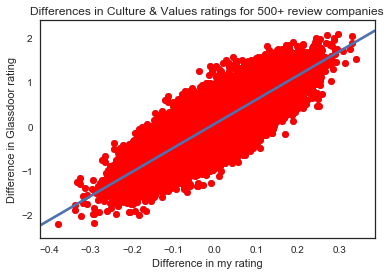

In [184]:
cat = 'Culture & Values'

plt.plot(my_rating_difference_by_category[cat],
         star_difference_by_category[cat],
        'ro')

#linear regression line
sns.regplot(np.asarray(my_rating_difference_by_category[cat]),np.asarray(star_difference_by_category[cat]));

plt.title('Differences in Culture & Values ratings for 500+ review companies')

plt.xlabel('Difference in my rating')
plt.ylabel('Difference in Glassdoor rating')

plt.savefig('culture_value_differences.png')

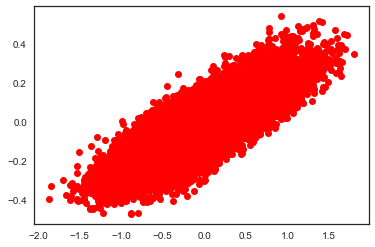

In [157]:
cat = 'Work/Life Balance'
plt.plot(star_difference_by_category[cat],
        my_rating_difference_by_category[cat],
        'ro')

plt.show()

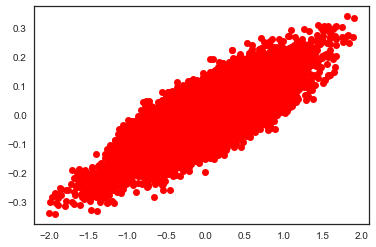

In [158]:
cat = 'Senior Management'
plt.plot(star_difference_by_category[cat],
        my_rating_difference_by_category[cat],
        'ro')

plt.show()

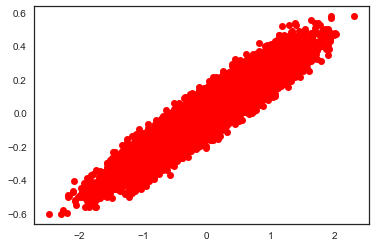

In [159]:
cat = 'Comp & Benefits'
plt.plot(star_difference_by_category[cat],
        my_rating_difference_by_category[cat],
        'ro')



plt.show()

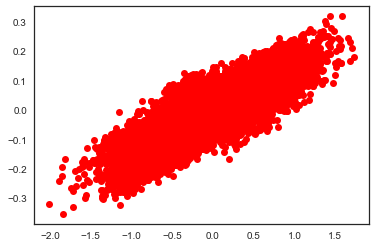

In [160]:
cat = 'Career Opportunities'
plt.plot(star_difference_by_category[cat],
        my_rating_difference_by_category[cat],
        'ro')

plt.show()

## Correlation coefficients

We finally calculate the correlation coefficients for each category.

In [167]:
#found this function on Stack Overflow
def polyfit(x, y, degree):
    '''
    Calculates the linear regression and correlation coefficient for x vs. y.
    
    Args:
        x: array-like
        y: array-like (of equal length as x)
        degree: degree of polynomial to fit
        
    Returns: 
        Dictionary
            Keys: determination (correlation coefficient), polynomial (best coefficients)
    '''
    results = {}

    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results

In [168]:
polyfit(star_difference_by_category[cat], my_rating_difference_by_category[cat], 1)

{'determination': 0.6977182627108542,
 'polynomial': [0.12749522110774775, -0.0061007386769575045]}

In [176]:
for cat in categories:
    print(cat)
    print(np.sqrt(polyfit(my_rating_difference_by_category[cat], star_difference_by_category[cat], 1)['determination']))
    

Culture & Values
0.8352953146707223
Work/Life Balance
0.8508941587913612
Senior Management
0.7793160046697644
Comp & Benefits
0.9404379315416758
Career Opportunities
0.8429278003097757
